# Step 1: Data Acquisition

In [1]:
import json
import requests

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'


In [3]:
headers = {
    'User-Agent': 'https://github.com/kevSweet',
    'From': 'ksweet1@uw.edu'
}

# dump dictionary to file
def write_to_json(data, fn):
    with open(fn, "w") as outfile:
        json.dump(data, outfile)
        
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [4]:
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# pagecounts dump

# desktop
monthly_legacy = api_call(endpoint_legacy, params_legacy)
first_date = monthly_legacy['items'][0]['timestamp']
last_date = monthly_legacy['items'][-1]['timestamp']
legacy_desktopfn = 'pagecounts_desktop-site_' + first_date + '-' + last_date + '.json'
write_to_json(monthly_legacy, legacy_desktopfn)

# mobile
params_legacy['access-site'] = "mobile-site"
monthly_legacy = api_call(endpoint_legacy, params_legacy)
first_date = monthly_legacy['items'][0]['timestamp']
last_date = monthly_legacy['items'][-1]['timestamp']
legacy_mobilefn = 'pagecounts_mobile-site_' + first_date + '-' + last_date + '.json'
write_to_json(monthly_legacy, legacy_mobilefn)

In [5]:

params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021110100'
                        }

# pageviews dump

# desktop
monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
first_date = monthly_pageviews['items'][0]['timestamp']
last_date = monthly_pageviews['items'][-1]['timestamp']
pageviews_desktopfn = 'pageviews_desktop-site_'+ first_date + '-' + last_date + '.json'
write_to_json(monthly_pageviews, pageviews_desktopfn)

# mobile app
params_pageviews['access'] = "mobile-app"
monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
first_date = monthly_pageviews['items'][0]['timestamp']
last_date = monthly_pageviews['items'][-1]['timestamp']
pageviews_mobileappfn = 'pageviews_mobile-app_'+ first_date + '-' + last_date + '.json'
write_to_json(monthly_pageviews, pageviews_mobileappfn)

# mobile web
params_pageviews['access'] = "mobile-web"
monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
first_date = monthly_pageviews['items'][0]['timestamp']
last_date = monthly_pageviews['items'][-1]['timestamp']
pageviews_mobilewebfn = 'pageviews_mobile-web_'+ first_date + '-' + last_date + '.json'
write_to_json(monthly_pageviews, pageviews_mobilewebfn)

# Step 2: Data Processing

In [6]:
import pandas as pd
import datetime

In [7]:
def convert_dates(items_dict):
    for item in items_dict:
        datee = datetime.datetime.strptime(item['timestamp'], "%Y%m%d%H")
        item['year'] = datee.year
        item['month'] = datee.strftime("%m")
        del(item['timestamp'])
    return pd.DataFrame(items_dict)

def tabularize_data(items_dict, api):
    items_dict = convert_dates(items_dict)
    items_dict_tabularized = pd.json_normalize(items_dict['items'])
    if api == 'pagecounts':
        items_dict_tabularized = items_dict_tabularized.drop(['project', 'access-site', 'granularity'], axis=1)
    elif api == 'pageviews':
        items_dict_tabularized = items_dict_tabularized.drop(['project', 'access', 'granularity', 'agent'], axis=1)
    else:
        raise Exception('please enter valid api (pagecounts or pageviews)')
        
    return items_dict_tabularized

In [8]:
# Desktop Pagecounts
pagecounts_desktop = pd.read_json('./pagecounts_desktop-site_2007120100-2016080100.json')
pagecounts_desktop_tabular = tabularize_data(pagecounts_desktop['items'], 'pagecounts')
pagecounts_desktop_tabular

,count,year,month
0,2998331524,2007,12
1,4930902570,2008,01
2,4818393763,2008,02
3,4955405809,2008,03
4,5159162183,2008,04
...,...,...,...
100,5572235399,2016,04
101,5330532334,2016,05
102,4975092447,2016,06
103,5363966439,2016,07


In [9]:
# Mobile Pagecounts
pagecounts_mobile = pd.read_json('./pagecounts_mobile-site_2014100100-2016080100.json')
pagecounts_mobile_tabular = tabularize_data(pagecounts_mobile['items'], 'pagecounts')
pagecounts_mobile_tabular

,count,year,month
0,3091546685,2014,10
1,3027489668,2014,11
2,3278950021,2014,12
3,3485302091,2015,01
4,3091534479,2015,02
5,3330832588,2015,03
6,3222089917,2015,04
7,3334069483,2015,05
8,3038162463,2015,06
9,3254472695,2015,07


In [10]:
# Desktop Pageviews
pageviews_desktop = pd.read_json('./pageviews_desktop-site_2015070100-2021090100.json')
pageviews_desktop_tabular = tabularize_data(pageviews_desktop['items'], 'pageviews')
pageviews_desktop_tabular

,views,year,month
0,4376666686,2015,07
1,4332482183,2015,08
2,4485491704,2015,09
3,4477532755,2015,10
4,4287720220,2015,11
...,...,...,...
70,2824416177,2021,05
71,2505971366,2021,06
72,2765584368,2021,07
73,2763413934,2021,08


In [11]:
# Mobile Pageviews
pageviews_mobileweb = pd.read_json('./pageviews_mobile-web_2015070100-2021090100.json')
pageviews_mobileapp = pd.read_json('./pageviews_mobile-app_2015070100-2021090100.json')
pageviews_mobile = pageviews_mobileweb.append(pageviews_mobileapp, ignore_index=True)

pageviews_mobile_tabular = tabularize_data(pageviews_mobile['items'], 'pageviews')
pageviews_mobile_tabular = pd.DataFrame(pageviews_mobile_tabular.groupby(['year', 'month']).views.agg(sum))
pageviews_mobile_tabular

views
year month            
2015 07     3288755294
     08     3302333038
     09     3170203333
     10     3268499132
     11     3236601070
...                ...
2021 05     4976579558
     06     4584510417
     07     4778909421
     08     4732194000
     09     4373512692

[75 rows x 1 columns]

In [16]:
merged = pd.merge(pagecounts_desktop_tabular, pagecounts_mobile_tabular, on=['year', 'month'], how='outer')
merged = pd.merge(merged, pageviews_desktop_tabular, on=['year', 'month'], how='outer')
merged = pd.merge(merged, pageviews_mobile_tabular, on=['year', 'month'], how='outer')
merged

,count_x,year,month,count_y,views_x,views_y
0,2.998332e+09,2007,12,NaN,NaN,NaN
1,4.930903e+09,2008,01,NaN,NaN,NaN
2,4.818394e+09,2008,02,NaN,NaN,NaN
3,4.955406e+09,2008,03,NaN,NaN,NaN
4,5.159162e+09,2008,04,NaN,NaN,NaN
...,...,...,...,...,...,...
161,NaN,2021,05,NaN,2.824416e+09,4.976580e+09
162,NaN,2021,06,NaN,2.505971e+09,4.584510e+09
163,NaN,2021,07,NaN,2.765584e+09,4.778909e+09
164,NaN,2021,08,NaN,2.763414e+09,4.732194e+09


In [24]:
merged = merged.rename(columns={"count_x": "pagecount_desktop_views", "count_y": "pagecount_mobile_views", 
                                "views_x": "pageview_desktop_views", "views_y": "pageview_mobile_views"})
merged = merged.fillna(0)
merged['pagecount_all_views'] = merged['pagecount_desktop_views'] + merged['pagecount_mobile_views']
merged['pageview_all_views'] = merged['pageview_desktop_views'] + merged['pageview_mobile_views']
merged = merged.reindex(columns=["year", "month", "pagecount_all_views", "pagecount_desktop_views",
                                 "pagecount_mobile_views", "pageview_all_views", "pageview_desktop_views",
                                 "pageview_mobile_views"])
merged

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
161,2021,05,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,06,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,07,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,08,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


In [27]:
wikitraffic_fn = 'en-wikipedia_traffic_200712-202108.csv'
merged.to_csv(wikitraffic_fn, index=False)

# Step 3: Analysis

In [38]:
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv('./' + wikitraffic_fn)
df['date'] = df['month'].map(str)+ '-' +df['year'].map(str)
df['date'] = pd.to_datetime(df['date'], format='%m-%Y').dt.strftime('%m-%Y')
df['all_views'] = df['pagecount_all_views'] + df['pageview_all_views'] 
df['desktop_views'] = df['pagecount_desktop_views'] + df['pageview_desktop_views']
df['mobile_views'] = df['pagecount_mobile_views'] + df['pageview_mobile_views']
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,date,all_views,desktop_views,mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,12-2007,2.998332e+09,2.998332e+09,0.000000e+00
1,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,01-2008,4.930903e+09,4.930903e+09,0.000000e+00
2,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,02-2008,4.818394e+09,4.818394e+09,0.000000e+00
3,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,03-2008,4.955406e+09,4.955406e+09,0.000000e+00
4,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,04-2008,5.159162e+09,5.159162e+09,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021,5,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09,05-2021,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,6,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09,06-2021,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,7,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09,07-2021,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,8,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09,08-2021,7.495608e+09,2.763414e+09,4.732194e+09


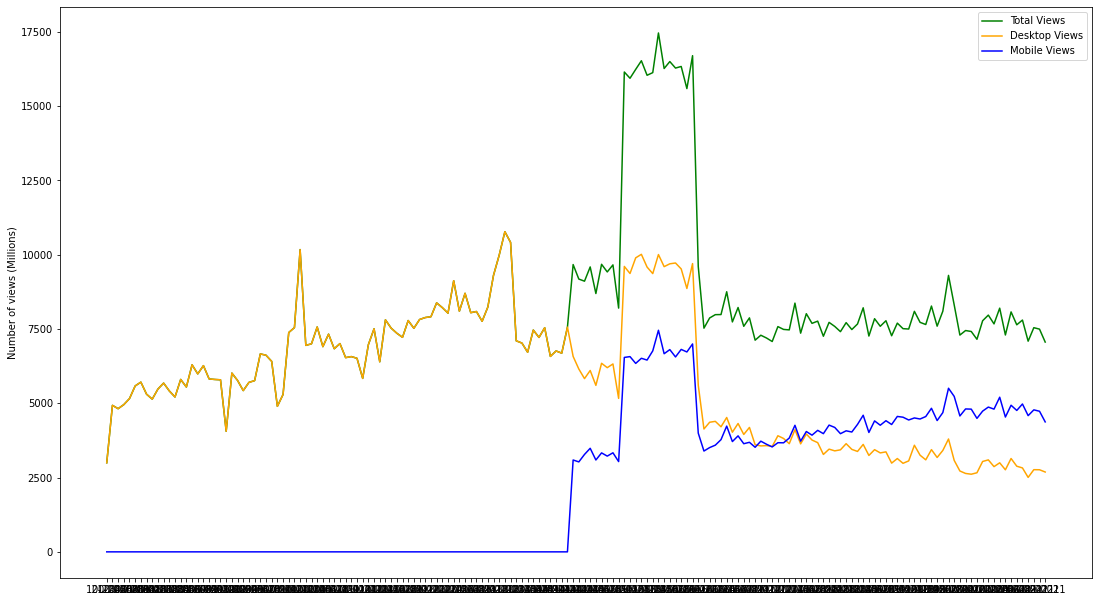

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot_date(df['date'], df['all_views']/1000000, 'b-', label = 'Total Views', color='green')
plt.plot_date(df['date'], df['desktop_views']/1000000, 'b-', label = 'Desktop Views', color = 'orange')
plt.plot_date(df['date'], df['mobile_views']/1000000, 'b-', label = 'Mobile Views', color= 'blue')
plt.legend()
plt.ylabel('Number of views (Millions)')

plt.show()